In [17]:
import numpy as np
import matplotlib.pyplot as plt

import noise as nm
from tqdm import tqdm


In [177]:

class bandit_game():
    def __init__(self, noise, taus, om0=10, n_steps=1000, eps=0.1, nrot = 1):
        self.om0 = om0
        self.noise = noise
        self.n_steps = n_steps
        self.n_taus = len(taus)
        self.taus = taus
        self.nrot = nrot
        self.Q = np.exp(-(om0-1e3/taus)**2/noise.sigma**2/4)
        self.N = np.zeros( self.n_taus)
        self.eps = eps
        noise.reset(x0 = np.random.normal(0, noise.sigma))        
        self.update_om()
    

    def reset_game(self):
        self.Q = np.random.uniform(size =  self.n_taus) + 1
        self.N = np.zeros( self.n_taus)
        self.noise.reset(x0 = np.random.normal(0, self.noise.sigma))
        self.update_om()

    def evaluate_prob(self, tau, om):
        return 1/2 + 1/2*np.cos(2*self.nrot*np.pi*tau*om*1e-3)

    def update_om(self):
        self.om = self.om0 + self.noise.update(1)

    def get_reward(self, tau):
        return np.random.binomial(1, self.evaluate_prob(tau, self.om))
    
    def select_action(self):
        if np.random.rand() < self.eps:
            return np.random.randint(self.n_taus)
        else:
            #get maxium index
            return np.argmax(self.Q)

    def update_Q(self, tau_ind, reward):
        self.N[tau_ind] += 1
        self.Q[tau_ind] += 1/self.N[tau_ind]*(reward - self.Q[tau_ind])


    def play(self):
        rewards = np.zeros(self.n_steps)
        actions = np.zeros(self.n_steps)
        oms = np.zeros(self.n_steps)
        for i in tqdm(range(self.n_steps)):
            self.update_om()
            action = self.select_action()
            reward = self.get_reward(self.taus[action])
            self.update_Q(action, reward)
            rewards[i] = reward
            actions[i] = action
            oms[i] = self.om
        return rewards, actions, oms
    
    def play_n(self, n):
        rewards = np.zeros((n, self.n_steps))
        actions = np.zeros((n, self.n_steps))
        oms = np.zeros((n, self.n_steps))
        for i in tqdm(range(n)):
            rewards[i], actions[i], oms[i] = self.play()
            self.reset_game()
        return rewards, actions, oms
    
    



In [192]:
noise = nm.OU_noise(2, 1/1000)
om0 = 10
n_steps = 1000

nplay = 3
taus = np.arange(1,190,1)
epsilons = [0, 0.01]
rewards = []
actions = []
oms = []

for eps in epsilons:
    game = bandit_game(noise, taus, om0, n_steps, eps = eps, nrot = 1)
    reward, action,om = game.play_n(nplay)
    actions.append(action)
    rewards.append(reward)
    oms.append(om)
    


100%|██████████| 3/3 [00:00<00:00, 53.26it/s]


In [193]:
actions[0].T

array([[ 99., 147.,  31.],
       [ 99.,  69., 123.],
       [ 99.,  38.,  75.],
       ...,
       [ 99.,   0.,   1.],
       [ 99.,   0.,   1.],
       [ 99.,   0.,   1.]])

Text(0.5, 0, 'Time [steps]')

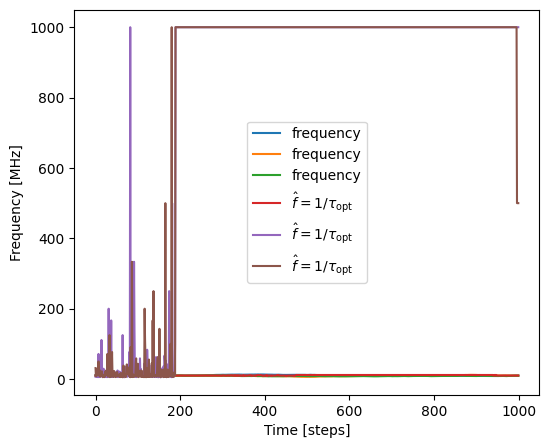

In [194]:
plt.figure(figsize=(6,5))
plt.plot(oms[0].T, label = "frequency")
plt.plot(1e3/taus[actions[0].T.astype(int)], label = r"$\hat f = 1/\tau_\mathrm{opt}$")
plt.legend()
plt.ylabel("Frequency [MHz]")
plt.xlabel("Time [steps]")

(0.0, 20.0)

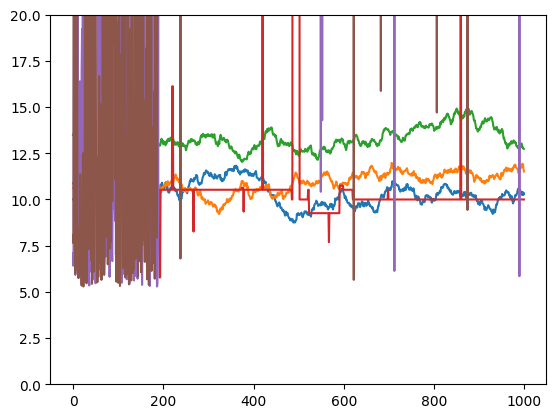

In [195]:
plt.plot(oms[1].T)
plt.plot(1e3/taus[actions[1].T.astype(int)])
plt.ylim(0,20)

In [187]:
plt.plot(taus[actions[2].T.astype(int)])

IndexError: list index out of range